# Comparing Vanilla and KeOps-Based Multi-Head Attention

Attention mechanisms have revolutionized deep learning in recent years by allowing models to focus on different parts of the input. In this tutorial, we compare two implementations of multi-head self-attention: a conventional (vanilla) version using standard PyTorch and an optimized version based on **KeOps**.

## What is attention

The **attention mechanism** allows a model to assign varying levels of importance to different input elements. It was first popularized in machine translation and has since become central to many domains.
$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$
where:
- $Q$ (queries), $K$ (keys), and $V$ (values) are matrices derived from the input.
- $d_k$ is the dimensionality of the queries and keys.
- The scaling by $\sqrt{d_k}$ helps stabilize gradients by preventing overly large dot products.

## Self-attention

**Self-attention** is a variant where the queries, keys, and values all come from the same source. In a sequence (e.g., a sentence), each token is allowed to “attend” to every other token. This flexibility is a key strength of Transformer architectures.

## Multi-head attention
Instead of performing one single attention operation, multi-head attention splits the model’s representation into several “heads.” Each head independently computes attention:

**Advantages:**
- Allows the model to capture different types of relationships.
- Improves representation capacity by providing multiple subspaces for learning similarities.

The outputs of these heads are then concatenated and projected to form the final output.

## KeOps in attention
KeOps is designed for efficient computation of large-scale kernel operations, particularly when memory becomes a bottleneck. By using a specialized reduction operator, the KeOps-based attention can perform the softmax-weighted sum more efficiently, especially for long sequences.

## Implementation details
We implemented two variants of multi-head attention:

### Vanilla Multi-head attention
The vanilla implementation follows the standard procedure:

**Input Projection:**
The input tensor $X$ of shape $(\text{batch\_size}, \text{seq\_len}, d_{\text{model}})$ is projected into queries, keys, and values using separate linear layers.

**Head Splitting:**
The projections are reshaped into $(\text{batch\_size}$, $\text{num\_heads}$, $\text{seq\_len}$, $d_k)$ by splitting the model dimension.

**Scaled Dot-Product Attention:**
For each head, compute the dot products between queries and transposed keys, scale by $\sqrt{d_k}$, and apply softmax.

**Weighted Sum:**
Multiply the softmax scores by the values to obtain each head’s output.

**Concatenation and Projection:**
Concatenate the heads back to shape $(\text{batch\_size}, \text{seq\_len}, d_{\text{model}})$ and apply a final linear layer.

In [1]:
!python3 -c "import pykeops; pykeops.clean_pykeops();"

[KeOps] /home/nizarben/.cache/keops2.2.3/Linux_ankhhaf_5.15.0-131-generic_p3.12.2 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pykeops.torch import Genred

import numpy as np
import time

In [3]:
class VanillaMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Project input to Q, K, V
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape and transpose for multi-head: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        # Apply softmax to get attention weights
        weights = F.softmax(scores, dim=-1)

        # Compute weighted sum: (batch_size, num_heads, seq_len, d_k)
        output = torch.matmul(weights, V)

        # Reshape back: (batch_size, seq_len, d_model)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Final linear projection
        output = self.W_o(output)
        return output

In [4]:
class KeOpsMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections (same as vanilla)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Define KeOps reduction with self.reduction
        formula = '((Q|K)/D)'
        aliases = [
            f'Q = Vi({self.d_k})',  # Query vectors, i-dimension (seq_len)
            f'K = Vj({self.d_k})',  # Key vectors, j-dimension (seq_len)
            f'V = Vj({self.d_k})',  # Value vectors, j-dimension (seq_len)
            'D = Pm(1)',           # Scaling factor (scalar)
        ]
        formula2 = 'V'
        reduction_op = 'SumSoftMaxWeight'
        self.reduction = Genred(formula, aliases, reduction_op=reduction_op, formula2=formula2, axis=1)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Project input to Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape for multi-head: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Flatten batch and heads: (batch_size * num_heads, seq_len, d_k)
        Q_flat = Q.reshape(batch_size * self.num_heads, seq_len, self.d_k)
        K_flat = K.reshape(batch_size * self.num_heads, seq_len, self.d_k)
        V_flat = V.reshape(batch_size * self.num_heads, seq_len, self.d_k)

        # Define scaling factor D = sqrt(d_k)
        D = torch.tensor([np.sqrt(self.d_k)], dtype=x.dtype, device=x.device)

        # Apply KeOps reduction: (batch_size * num_heads, seq_len, d_k)
        output_flat = self.reduction(Q_flat, K_flat, V_flat, D)

        # Reshape back: (batch_size, seq_len, d_model)
        output = output_flat.view(batch_size, self.num_heads, seq_len, self.d_k)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Final linear projection
        output = self.W_o(output)
        return output

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def test_correctness(vanilla_attn, keops_attn, input_shapes, atol=1e-5, rtol=1e-5):
    """
    For each shape in input_shapes:
      - Runs a forward pass through both modules.
      - Checks that the outputs are allclose.
      - Computes a simple scalar loss (sum) and performs backward.
      - Compares the gradients of a representative parameter.
    """
    for shape in input_shapes:
        print(f"\nTesting shape: {shape}")
        # Create input with gradients enabled
        x = torch.randn(*shape, device=device, requires_grad=True)

        # Zero gradients
        vanilla_attn.zero_grad()
        keops_attn.zero_grad()

        # Forward pass
        out_v = vanilla_attn(x)
        out_k = keops_attn(x)

        # Check forward outputs
        if torch.allclose(out_v, out_k, atol=atol, rtol=rtol):
            print("  Forward outputs match.")
        else:
            diff = (out_v - out_k).abs().max().item()
            print(f"  Forward outputs differ! Max difference = {diff:.6f}")

        # Backward pass 
        loss_v = out_v.sum()
        loss_k = out_k.sum()
        loss_v.backward()
        loss_k.backward()

        # Compare gradients for one parameter
        grad_v = vanilla_attn.W_q.weight.grad
        grad_k = keops_attn.W_q.weight.grad

        if torch.allclose(grad_v, grad_k, atol=atol, rtol=rtol):
            print("  Gradients match for W_q.weight.")
        else:
            grad_diff = (grad_v - grad_k).abs().max().item()
            print(f"  Gradients differ for W_q.weight! Max gradient difference = {grad_diff:.6f}")

In [7]:
# Define a list of input shapes to test: (batch_size, seq_len, d_model)
d_model = 64
num_heads = 8
input_shapes = [
    (2, 10, d_model),
    (4, 128, d_model),
    (8, 256, d_model),
    (16, 1024, d_model),
]

# Initialize both models and copy weights to ensure they are identical.
torch.manual_seed(0)
vanilla_attn = VanillaMultiHeadAttention(d_model, num_heads).to(device)
keops_attn = KeOpsMultiHeadAttention(d_model, num_heads).to(device)
keops_attn.load_state_dict(vanilla_attn.state_dict())

# Run correctness tests
test_correctness(vanilla_attn, keops_attn, input_shapes)


Testing shape: (2, 10, 64)
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [(a|b)/d,([1,c])] with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,8,1), d=Var(3,1,2) ... OK
  Forward outputs match.
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (((Extract(e,1,9)|([1,c]))/d)*b)*Exp((a|b)/d-Extract(f,0,1)) with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,8,1), d=Var(3,1,2), e=Var(4,10,0), f=Var(5,10,0) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (((Extract(e,1,9)|([1,c]))/d)*a)*Exp((a|b)/d-Extract(f,0,1)) with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,8,1), d=Var(3,1,2), e=Var(4,10,0), f=Var(5,10,0) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Extract(Exp((a|b)/d-Extract(f,0,1))*Extract(e,1,9),1,8) with a=Var(0,8,0), b=Var(1,8,1), d=Var(3,1,2), e=Var(4,10,0), f=Var(5,10,0) ... OK
  Gradients match for W_q.weight.

Testing shape: (4, 128

In [8]:
def benchmark_time(module, input_generator, num_runs=10, backward=False):
    # Warm-up runs
    for _ in range(10):
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
    times = []
    for _ in range(num_runs):
        x = input_generator()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.time()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        times.append((time.time() - start) * 1000.0)  # time unit : milliseconds
    return np.mean(times), np.std(times)

In [9]:
def measure_memory_usage(module, input_generator, num_runs=5, backward=False):
    usage = []
    for _ in range(num_runs):
        torch.cuda.reset_peak_memory_stats(device)
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        usage.append(torch.cuda.max_memory_allocated(device))
    # Convert bytes to MB (torch memory functions return values in bytes)
    return np.mean(usage) / (1024**2), np.std(usage) / (1024**2)

In [10]:
seq_lengths = [128, 256, 512, 1024, 2048]

# Lists to hold benchmark results for each sequence length
vanilla_times = []  # forward-pass time in ms for Vanilla
keops_times = []    # forward-pass time in ms for KeOps

vanilla_memories = []  # GPU memory in MB for Vanilla
keops_memories = []    # GPU memory in MB for KeOps

In [11]:
for seq_len in seq_lengths:
    print(f"\nBenchmarking for seq_len = {seq_len}")
    
    # Define an input generator for this sequence length
    def input_generator(seq_len=seq_len, batch_size=32):
        return torch.randn(batch_size, seq_len, d_model, device=device)
    
    # Measure average forward pass time (ms)
    t_v, t_v_std = benchmark_time(vanilla_attn, input_generator, num_runs=10, backward=False)
    t_k, t_k_std = benchmark_time(keops_attn, input_generator, num_runs=10, backward=False)
    
    vanilla_times.append(t_v)
    keops_times.append(t_k)
    
    # Measure GPU memory usage (in MB)
    m_v, m_v_std = measure_memory_usage(vanilla_attn, input_generator, num_runs=5, backward=False)
    m_k, m_k_std = measure_memory_usage(keops_attn, input_generator, num_runs=5, backward=False)
    
    vanilla_memories.append(m_v)
    keops_memories.append(m_k)
    
    print(f"  Vanilla: {t_v:.2f} ms, {m_v:.2f} MB")
    print(f"  KeOps:   {t_k:.2f} ms, {m_k:.2f} MB")


Benchmarking for seq_len = 128
  Vanilla: 2.76 ms, 76.11 MB
  KeOps:   17.71 ms, 34.56 MB

Benchmarking for seq_len = 256
  Vanilla: 2.77 ms, 224.31 MB
  KeOps:   19.24 ms, 51.61 MB

Benchmarking for seq_len = 512
  Vanilla: 8.94 ms, 789.51 MB
  KeOps:   18.52 ms, 85.71 MB

Benchmarking for seq_len = 1024
  Vanilla: 31.30 ms, 2995.11 MB
  KeOps:   20.43 ms, 153.91 MB

Benchmarking for seq_len = 2048
  Vanilla: 138.66 ms, 11707.11 MB
  KeOps:   21.46 ms, 290.31 MB


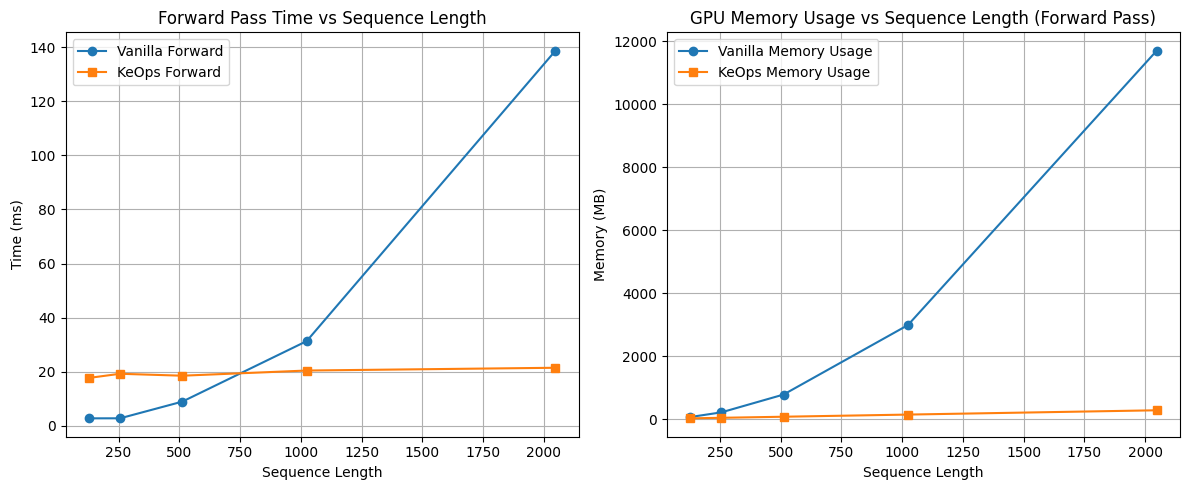

In [12]:
import matplotlib.pyplot as plt

# Plot the timing comparisons (line graphs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(seq_lengths, vanilla_times, marker='o', label="Vanilla Forward")
plt.plot(seq_lengths, keops_times, marker='s', label="KeOps Forward")
plt.xlabel("Sequence Length")
plt.ylabel("Time (ms)")
plt.title("Forward Pass Time vs Sequence Length")
plt.legend()
plt.grid(True)

# Plot the memory consumption comparisons (line graphs in MB)
plt.subplot(1, 2, 2)
plt.plot(seq_lengths, vanilla_memories, marker='o', label="Vanilla Memory Usage")
plt.plot(seq_lengths, keops_memories, marker='s', label="KeOps Memory Usage")
plt.xlabel("Sequence Length")
plt.ylabel("Memory (MB)")
plt.title("GPU Memory Usage vs Sequence Length (Forward Pass)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
keops_seq_lengths = [4096, 10000, 20000, 50000]
for seq_len in keops_seq_lengths:
    print(f"\nBenchmarking for seq_len = {seq_len}")
    # Define an input generator for this sequence length
    def input_generator(seq_len=seq_len, batch_size=256):
        return torch.randn(batch_size, seq_len, d_model, device=device)
    
    t_k, t_k_std = benchmark_time(keops_attn, input_generator, num_runs=10, backward=False)
    m_k, m_k_std = measure_memory_usage(keops_attn, input_generator, num_runs=5, backward=False)
    print(f"  KeOps:   {t_k:.2f} ms, {m_k:.2f} MB")


Benchmarking for seq_len = 4096
  KeOps:   314.13 ms, 4382.31 MB

Benchmarking for seq_len = 10000
  KeOps:   1311.94 ms, 10672.76 MB

Benchmarking for seq_len = 20000
  KeOps:   5137.37 ms, 21329.01 MB

Benchmarking for seq_len = 50000


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.05 GiB. GPU 0 has a total capacity of 44.34 GiB of which 1.14 GiB is free. Process 2131557 has 342.00 MiB memory in use. Process 13047 has 14.48 GiB memory in use. Including non-PyTorch memory, this process has 28.37 GiB memory in use. Of the allocated memory 25.20 GiB is allocated by PyTorch, and 2.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)